Credit Scoring Modeling - 
**Data Analytics**

### Pre-Processing

###### Import Libraries

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sklearn as skl
from pandas.io.parsers import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE                   # For Oversampling
# from outliers import smirnov_grubbs as grubbs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC


import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns

from sqlalchemy import types, create_engine
import math
import decimal
from datetime import datetime, date
from datetime import timedelta
import calendar as cd
# setup environment and import libraries
import os
import re
import datetime
import time
import getpass
import math
import decimal
import pandas as pd
import numpy as np
from datetime import datetime, date
from datetime import timedelta
import calendar as cd
from collections import OrderedDict
path=r'C:\ProgramData\Anaconda2\instantclient_12_2'
os.environ['PATH']=path
import cx_Oracle
import pickle


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Add path in order to load utility functions
import sys
sys.path.append(r"N:\18. Hot Spot\Custom Modules\Utils")
sys.path.append(r"N:\18. Hot Spot\Custom Modules\ETLMonthly")

import file_utils
import db_utils
import config

#set working directory
work_dir = config.working_dir+'\modeling'
if not os.path.exists(work_dir):
    os.mkdir(work_dir)
os.chdir(work_dir)

In [3]:
conn_string = db_utils.db_connect(config.db_username,config.db_pwd)

Enter username: data_analyst
Enter Password:········
Press 'y' to continue, 'c' to cancel or escape:y
Testing Connection...
Connection Succesful!


In [4]:
mtch = re.match('.*@', conn_string)
un, pwd = mtch.group().rstrip('@').split('/')

In [5]:
# variable/initialization declaration

# name of the database table for the output
db_table_nm='cs_model_v4'
dataset_read_from_addr=r'../df_loan_data_derived_var.csv'

In [6]:
# set target variable name
target_var='CLASS'

In [7]:
# dataset[dataset.CLASS==0]['DOES_IN_BRANCH'].value_counts()

###### Read, Transform and Partition Data

In [8]:
# read and transform data
# dataset = read_csv(dataset_read_from_addr, usecols = cols_selected)
dataset_original = read_csv(dataset_read_from_addr)
dataset_original = dataset_original.rename(columns={'IS_BAD':target_var})

# print 'old distros'
# print dataset[target_var].value_counts()
# bad_guys = dataset[dataset[target_var]==1]
# nbr_bad_cust_rows = len(bad_guys)
# sampled_good_guys = dataset[dataset[target_var]==0].sample(n=nbr_bad_cust_rows, random_state=42)
# dataset = pd.concat([sampled_good_guys,bad_guys])
# print 'new distros'
# print dataset[target_var].value_counts()


In [62]:
sampler = RandomUnderSampler(random_state=42)
# sampler = RandomOverSampler(random_state=42)

In [63]:
cols_selected_1 = pickle.load(open('../cols_selected_1.sav','rb'))
cols_selected_2_cat = pickle.load(open('../cols_selected_2_cat.sav','rb'))
cols_selected_2_numeric = pickle.load(open('../cols_selected_2_numeric.sav','rb'))

y = np.vstack(dataset_original[target_var].values)

# # Encode dataset and select columns for the first X
le = LabelEncoder()
X_cat = dataset_original[cols_selected_1].apply(lambda col: le.fit_transform(col)).values
print X_cat.shape
X_cat_train_original, X_cat_test, y_cat_train_original, y_cat_test = \
    train_test_split(X_cat, y, test_size=0.3, random_state=42)
    
X_cat_train, y_cat_train = sampler.fit_sample(X_cat_train_original, y_cat_train_original)
print('Training Set Shape after oversampling: ', X_cat_train.shape, y_cat_train.shape)

(154724L, 33L)
('Training Set Shape after oversampling: ', (18082L, 33L), (18082L,))


In [64]:
# MinMax Scaling for the second X
min_max_scaler = preprocessing.MinMaxScaler()
# prepare a new dataset that contains only fetures from cols_selected_2_*
dataset_2 = dataset_original[cols_selected_2_numeric+cols_selected_2_cat+['BRA_CODE','CUS_NUM',target_var]]
# get scaler for minmax scaling - numeric cols only
dataset_2_minmax_scaler = min_max_scaler.fit(dataset_2[cols_selected_2_numeric].values)
# transform basd on the scaler function defined above
dataset_2[cols_selected_2_numeric] = dataset_2_minmax_scaler.transform(dataset_2[cols_selected_2_numeric])
# label encoding of cat cols
dataset_2[cols_selected_2_cat] = dataset_2[cols_selected_2_cat].apply(lambda col: le.fit_transform(col)).values
# set X_minmax
X_minmax = dataset_2[cols_selected_2_numeric+cols_selected_2_cat]

print X_minmax.shape

X_minmax_train_original, X_minmax_test, y_minmax_train_original, y_minmax_test = \
    train_test_split(X_minmax, y, test_size=0.3, random_state=42)
    
X_minmax_train, y_minmax_train = sampler.fit_sample(X_minmax_train_original, y_minmax_train_original)
print('Training Set Shape after oversampling: ', X_minmax_train.shape, y_minmax_train.shape)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


(154724, 91)
('Training Set Shape after oversampling: ', (18082L, 91L), (18082L,))


In [65]:
# Standard Scaling for the second X
standard_scaler = preprocessing.StandardScaler()
# prepare a new dataset that contains only features from cols_selected_2_*
dataset_3 = dataset_original[cols_selected_2_numeric+cols_selected_2_cat+['BRA_CODE','CUS_NUM',target_var]]
# get scaler for standard scaling - numeric cols only
for c in cols_selected_2_numeric:
    dataset_3_standard_scaler = standard_scaler.fit(dataset_3[c].values)
    # transform basd on the scaler function defined above
    dataset_3[c] = dataset_3_standard_scaler.transform(dataset_3[c])
# label encoding of cat cols
dataset_3[cols_selected_2_cat] = dataset_3[cols_selected_2_cat].apply(lambda col: le.fit_transform(col)).values
# set X2
X_stand = dataset_3[cols_selected_2_numeric+cols_selected_2_cat]
print X_stand.shape
X_stand_train_original, X_stand_test, y_stand_train_original, y_stand_test = \
    train_test_split(X_stand, y, test_size=0.3, random_state=42)
    
X_stand_train, y_stand_train = sampler.fit_sample(X_stand_train_original, y_stand_train_original)
print('Training Set Shape after oversampling: ', X_stand_train.shape, y_stand_train.shape)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

(154724, 91)
('Training Set Shape after oversampling: ', (18082L, 91L), (18082L,))


In [12]:
# cols_selected_1 = pickle.load('cols_selected_1.sav','rb')
# cols_selected_2_cat = pickle.load('cols_selected_2_cat.sav','rb')
# cols_selected_2_numeric = pickle.load('cols_selected_2_numeric.sav','rb')

# # Encode dataset and select columns for the first X
# le = LabelEncoder()
# X = dataset[cols_selected_1].apply(lambda col: le.fit_transform(col)).values
# print('Variables selected for X1:  ', list(cols_selected_1))


# # MinMax Scaling for the second X
# min_max_scaler = preprocessing.MinMaxScaler()
# X2 = min_max_scaler.fit(dataset[cols_selected_2_numeric].values)
# X2+dataset[cols_selected_2_cat]

# # Standardization Scaling for the second X
# min_max_scaler = preprocessing.st
# X3 = min_max_scaler.fit(dataset[cols_selected_2_numeric].values)


# # # Normalization - Using MinMax Scaler
# # min_max_scaler = preprocessing.MinMaxScaler()
# # min_max_scaler.fit(X)
# # X = min_max_scaler.transform(X)
# # print min_max_scaler.data_max_
# # pickle.dump(min_max_scaler, open('min_max_scaler.sav', 'wb'))

# # y = np.vstack(dataset[target_var].values)

# print('\n')
# print('X and y Input Data:   ', X.shape, y.shape)
# X_train_original, X_test, y_train_original, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print('Training Set Shape:   ', X_train_original.shape, y_train_original.shape)
# print('Test Set Shape:       ', X_test.shape, y_test.shape)

#### Check correlation between variables

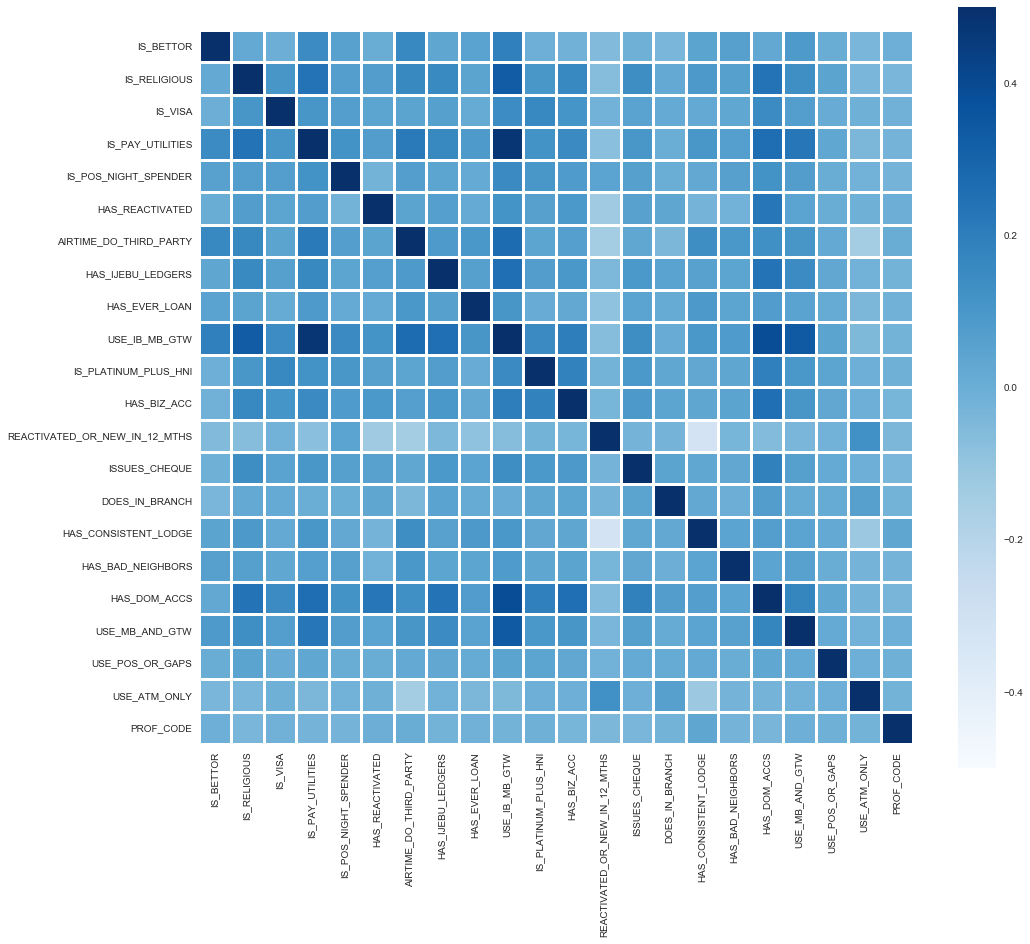

In [23]:
corr = dataset_original[cols_selected_1].corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, vmax=0.5, center=0, square=True, linewidths=2, cmap='Blues')
# plt.savefig("heatmap.png")
plt.show()

###### re-sampling of Imbalanced dataset

In [14]:
# samplingTechnique = ''

# if samplingTechnique=='under':
#     rus = RandomUnderSampler(random_state=42)
#     X_train, y_train = rus.fit_sample(X_train_original, y_train_original)
#     print('Training Set Shape after undersampling: ', X_train.shape, y_train.shape)
# elif samplingTechnique=='over':
#     ros = RandomOverSampler(random_state=42)
#     X_train, y_train = ros.fit_sample(X_train_original, y_train_original)
#     print('Training Set Shape after oversampling: ', X_train.shape, y_train.shape)
# else:
#     X_train = X_train_original
#     y_train = y_train_original
    

In [14]:
# # check
# print 'frequency table of original data outcome'
# print '-----------------------------------------'
# print pd.Series(y_train_original.flatten()).value_counts()
# print '\nfrequency table of oversampled/undersampled data outcome'
# print '---------------------------------------------'
# print pd.Series(y_train.flatten()).value_counts()

### Build Models

###### Decision Tree Classifier

In [16]:
clf_DT = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, 
                                min_samples_split=2, min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0, max_features=None, 
                                max_leaf_nodes=None, min_impurity_split=1e-07, random_state=42)
clf_DT.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_DT, open('clf_DT.sav', 'wb'))

###### Naive Bayes Classifier

In [17]:
clf_NB = BernoulliNB()
clf_NB.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_NB, open('clf_NB.sav', 'wb'))

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###### Neural Network Classifier

In [77]:
# MLPClassifier(activation='relu', alpha=1e-05,
#        batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
#        epsilon=1e-08, hidden_layer_sizes=(64), learning_rate='constant',
#        learning_rate_init=0.001, max_iter=2000, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
#        tol=0.001, validation_fraction=0.1, verbose=True,
#        warm_start=False)

clf_MLP = MLPClassifier(activation='relu', alpha=1e-05,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(200), learning_rate='constant',
       learning_rate_init=0.0001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, validation_fraction=0.1, verbose=True,
       warm_start=False)


clf_MLP.fit(X_minmax_train, y_minmax_train)
# write the model to disk
pickle.dump(clf_MLP, open('clf_MLP.sav', 'wb'))
print 'Training dataset accuracy: ', clf_MLP.score(X_minmax_train, y_minmax_train)
print 'Test dataset accuracy: ', clf_MLP.score(X_minmax_test, y_minmax_test)

Iteration 1, loss = 0.86010741
Iteration 2, loss = 0.67489344
Iteration 3, loss = 0.66399006
Iteration 4, loss = 0.65513902
Iteration 5, loss = 0.65048219
Iteration 6, loss = 0.64501775
Iteration 7, loss = 0.64031222
Iteration 8, loss = 0.63763848
Iteration 9, loss = 0.63457858
Iteration 10, loss = 0.63216173
Iteration 11, loss = 0.63008668
Iteration 12, loss = 0.62847055
Iteration 13, loss = 0.62663166
Iteration 14, loss = 0.62513574
Iteration 15, loss = 0.62421169
Iteration 16, loss = 0.62330567
Iteration 17, loss = 0.62294973
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Training dataset accuracy:  0.662647937175
Test dataset accuracy:  0.630595889526


In [78]:
y_MLP_predict_minmax_train = clf_MLP.predict(X_minmax_train)
y_MLP_predict_minmax_test = clf_MLP.predict(X_minmax_test)
print accuracy_score(y_minmax_train, y_MLP_predict_minmax_train)
print recall_score(y_minmax_train, y_MLP_predict_minmax_train)
print accuracy_score(y_minmax_test, y_MLP_predict_minmax_test)
print recall_score(y_minmax_test, y_MLP_predict_minmax_test)

0.662647937175
0.701692290676
0.630595889526
0.697948717949


In [80]:
clf_MLP.fit(X_stand_train, y_stand_train)
y_MLP_predict_stand_train = clf_MLP.predict(X_stand_train)
y_MLP_predict_stand_test = clf_MLP.predict(X_stand_test)
print accuracy_score(y_stand_train, y_MLP_predict_stand_train)
print recall_score(y_stand_train, y_MLP_predict_stand_train)
print accuracy_score(y_stand_test, y_MLP_predict_stand_test)
print recall_score(y_stand_test, y_MLP_predict_stand_test)

Iteration 1, loss = 0.83003890
Iteration 2, loss = 0.64702335
Iteration 3, loss = 0.63400296
Iteration 4, loss = 0.62617095
Iteration 5, loss = 0.62224065
Iteration 6, loss = 0.61810121
Iteration 7, loss = 0.61445184
Iteration 8, loss = 0.61263058
Iteration 9, loss = 0.61064217
Iteration 10, loss = 0.60848622
Iteration 11, loss = 0.60692712
Iteration 12, loss = 0.60572050
Iteration 13, loss = 0.60437177
Iteration 14, loss = 0.60292140
Iteration 15, loss = 0.60235142
Iteration 16, loss = 0.60143164
Iteration 17, loss = 0.60088514
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
0.687036832209
0.719500055304
0.655133784308
0.712820512821


###### Logistic Regression Classifier

In [73]:
#clf_Log = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42,verbose=2) start: 3:10pm
clf_Log = LogisticRegression(solver='sag', max_iter=1000, n_jobs=-1,
                             random_state=42,verbose=2,class_weight='balanced')

clf_Log.fit(X_stand_train, y_stand_train)
# write the model to disk
pickle.dump(clf_Log, open('clf_Log.sav', 'wb'))
print(clf_Log.coef_)
print(clf_Log.intercept_)
print 'Training dataset accuracy: ', clf_Log.score(X_stand_train, y_stand_train)

max_iter reached after 55 seconds
[[ -3.46035678e-01  -1.65861472e-01  -6.58771375e-02  -6.03585456e-02
    2.22984783e-02  -1.44195748e-02   1.14356225e-01  -1.37344213e-01
    7.97070893e-02   1.31761225e-01  -1.08446993e-01   3.65509605e-02
   -1.80271431e-01  -2.44606547e-01   4.68373809e-02   1.71154773e-01
   -8.85099664e-02   3.44070178e-02   6.20561916e-02  -6.01530222e-02
   -2.26912541e-02   3.06071236e-01  -4.05872526e-02  -4.31272882e-02
    1.70740243e-01  -8.20390359e-02  -4.06809790e-02  -1.97823184e-01
    1.82290492e-02   1.65133910e-01  -6.30382763e-02   1.54214488e-01
    1.50215246e-01  -8.38867473e-03  -4.59779801e-02   3.79736988e-02
   -8.65757762e-02   1.33850511e-01  -2.68619272e-02   9.15864218e-02
   -5.36817933e-02  -1.28952481e-02   6.58966658e-03   1.23024553e-01
    2.36916725e-02  -1.47479409e-01  -1.69350749e-02  -1.79378629e-01
   -9.81071353e-03  -7.28745173e-02   3.02184411e-02  -4.57382662e-02
    1.08562555e-01   1.61595747e-01  -4.37788638e-04  -7

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   54.6s finished


In [74]:
clf_Log.fit(X_minmax_train, y_minmax_train)
print 'Training dataset accuracy: ', clf_Log.score(X_minmax_train, y_minmax_train)

max_iter reached after 53 seconds
Training dataset accuracy:  0.669339674815


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   53.6s finished


In [75]:
clf_Log.fit(X_cat_train, y_cat_train)
print 'Training dataset accuracy: ', clf_Log.score(X_cat_train, y_cat_train)

max_iter reached after 18 seconds
Training dataset accuracy:  0.659661541865


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.6s finished


In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, accuracy_score

In [69]:
clf_KNN = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
clf_KNN.fit(X_minmax_train, y_minmax_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

In [70]:
y_KNN_predict_minmax_train = clf_KNN.predict(X_minmax_train)
y_KNN_predict_minmax_test = clf_KNN.predict(X_minmax_test)
print accuracy_score(y_minmax_train, y_KNN_predict_minmax_train)
print recall_score(y_minmax_train, y_KNN_predict_minmax_train)
print accuracy_score(y_minmax_test, y_KNN_predict_minmax_test)
print recall_score(y_minmax_test, y_KNN_predict_minmax_test)

# 1.0
# 1.0
# 0.859601878582
# 0.153333333333

0.790399292114
0.580798584227
0.75158343746
0.36358974359


In [71]:
# clf_KNN.predict_proba(X_minmax_test).reshape([1,-1])

In [72]:
clf_KNN = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
clf_KNN.fit(X_stand_train, y_stand_train)
y_KNN_predict_stand_train = clf_KNN.predict(X_stand_train)
y_KNN_predict_stand_test = clf_KNN.predict(X_stand_test)

print accuracy_score(y_stand_train, y_KNN_predict_stand_train)
print recall_score(y_stand_train, y_KNN_predict_stand_train)
print accuracy_score(y_stand_test, y_KNN_predict_stand_test)
print recall_score(y_stand_test, y_KNN_predict_stand_test)

# 1.0
# 1.0
# 0.863027273902
# 0.165384615385

0.798639531025
0.597279062051
0.757464776595
0.384615384615


In [76]:
clf_KNN = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
clf_KNN.fit(X_cat_train, y_cat_train)
y_KNN_predict_cat_train = clf_KNN.predict(X_cat_train)
y_KNN_predict_cat_test = clf_KNN.predict(X_cat_test)

print accuracy_score(y_cat_train, y_KNN_predict_cat_train)
print recall_score(y_cat_train, y_KNN_predict_cat_train)
print accuracy_score(y_cat_test, y_KNN_predict_cat_test)
print recall_score(y_cat_test, y_KNN_predict_cat_test)


0.787246985953
0.574604579139
0.754901115946
0.356666666667


###### Random Forest Classifier

In [20]:
clf_RF = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=15,
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07, 
                                bootstrap=True, oob_score=False, n_jobs=-1, 
                                random_state=42, verbose=1, warm_start=False, class_weight=None)
clf_RF.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_RF, open('clf_RF.sav', 'wb'))

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.5s finished


###### AdaBoost Classifier

In [21]:
clf_AdaB = AdaBoostClassifier(n_estimators=100)
clf_AdaB.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_AdaB, open('clf_AdaB.sav', 'wb'))

###### Gradient Boost Classifier

In [22]:
clf_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
clf_GB.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_GB, open('clf_GB.sav', 'wb'))

###### Extra Tree Classifier

In [23]:
clf_ET = ExtraTreesClassifier(n_estimators=50, random_state=42, max_depth=15)
clf_ET.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_ET, open('clf_ET.sav', 'wb'))

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Feature Importance 

In [24]:
importances_RF = clf_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_RF.estimators_],
             axis=0)
# indices1 = np.argsort(importances_RF[0:var])[::-1]
indices1 = np.argsort(importances_RF)[::-1]

indices = indices1
# indices = indices1[0:var]
# Print the feature ranking
print("Feature ranking:")
features_ranking=pd.DataFrame(columns=['FEATURE','IMPORTANCE'])
var=len(cols_selected)
for f in range(var):
    features_ranking=features_ranking.append({
        features_ranking.columns[0]:cols_selected[indices[f]],
        features_ranking.columns[1]:importances_RF[indices[f]]
    }, ignore_index=True)
    print("%d. %s (%f)" % (f + 1, cols_selected[indices[f]], importances_RF[indices[f]]))

features_ranking.to_csv('features_ranking_based_on_randomforest.csv', index=False)

Feature ranking:
1. STATE (0.119355)
2. PROF_CODE (0.103229)
3. BANK_YRS_BIN (0.085046)
4. CUS_AGE_AT_LOAN_BIN (0.073173)
5. COV_LODGEMENT_CNT_BIN (0.060800)
6. NTWRK_OUT_IN_DEGREE_RATIO_BIN (0.050482)
7. AIRTIME_AVG_PER_MONTH_COUNT_BIN (0.050282)
8. NTWRK_DEGREE_BIN (0.046182)
9. AIRTIME_NBR_MONTH_ACTIVE_RATIO_BIN (0.042582)
10. HAS_CONSISTENT_LODGE (0.037626)
11. HAS_BAD_NEIGHBORS (0.029499)
12. DOES_IN_BRANCH (0.027622)
13. HAS_EVER_LOAN (0.027279)
14. CUS_GENDER (0.024937)
15. HAS_REACTIVATED (0.024117)
16. NBR_DISTINCT_DEP_BIN (0.023735)
17. IS_BETTOR (0.022084)
18. USE_IB_MB_GTW (0.020584)
19. AIRTIME_DO_THIRD_PARTY (0.020407)
20. IS_PAY_UTILITIES (0.018177)
21. IS_RELIGIOUS (0.017713)
22. HAS_DOM_ACCS (0.011819)
23. REACTIVATED_OR_NEW_IN_12_MTHS (0.010792)
24. IS_POS_NIGHT_SPENDER (0.010118)
25. HAS_BIZ_ACC (0.008573)
26. HAS_IJEBU_LEDGERS (0.008115)
27. USE_MB_AND_GTW (0.007966)
28. AVG_TURNOVER_AMOUNT_BIN (0.005630)
29. ISSUES_CHEQUE (0.003666)
30. USE_ATM_ONLY (0.002374)
31. 

### Model Evaluation

In [25]:
# Training dataset

In [26]:
y_train_pred_DT_proba = [i[1] for i in clf_DT.predict_proba(X_train)]
y_train_pred_NB_proba = [i[1] for i in clf_NB.predict_proba(X_train)]
y_train_pred_MLP_proba = [i[1] for i in clf_MLP.predict_proba(X_train)]
y_train_pred_Log_proba = [i[1] for i in clf_Log.predict_proba(X_train)]
y_train_pred_RF_proba = [i[1] for i in clf_RF.predict_proba(X_train)]
y_train_pred_AdaB_proba = [i[1] for i in clf_AdaB.predict_proba(X_train)]
y_train_pred_GB_proba = [i[1] for i in clf_GB.predict_proba(X_train)]
y_train_pred_ET_proba = [i[1] for i in clf_ET.predict_proba(X_train)]

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.3s finished


In [27]:
# Test dataset

In [28]:
y_test_pred_DT_proba = [i[1] for i in clf_DT.predict_proba(X_test)]
y_test_pred_NB_proba = [i[1] for i in clf_NB.predict_proba(X_test)]
y_test_pred_MLP_proba = [i[1] for i in clf_MLP.predict_proba(X_test)]
y_test_pred_Log_proba = [i[1] for i in clf_Log.predict_proba(X_test)]
y_test_pred_RF_proba = [i[1] for i in clf_RF.predict_proba(X_test)]
y_test_pred_AdaB_proba = [i[1] for i in clf_AdaB.predict_proba(X_test)]
y_test_pred_GB_proba = [i[1] for i in clf_GB.predict_proba(X_test)]
y_test_pred_ET_proba = [i[1] for i in clf_ET.predict_proba(X_test)]

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.4s finished


In [29]:
def evaluate_model(y, y_pred_dict, threshold=0.5):
    model_evaluation_result = pd.DataFrame()
    model_evaluation_scores_dict = {}
    for k in y_pred_dict:
        y_pred_binary = ([int(i>=threshold) for i in y_pred_dict[k]])
        model_evaluation_scores_dict[k+' proba'] = y_pred_dict[k]
        model_evaluation_scores_dict[k] = y_pred_binary
        
        y_zipped = zip(y, y_pred_binary)
        tp = len([t for t in y_zipped if (t[0]==1) & (t[1]==1)])
        fp = len([t for t in y_zipped if (t[0]==0) & (t[1]==1)])
        tn = len([t for t in y_zipped if (t[0]==0) & (t[1]==0)])
        fn = len([t for t in y_zipped if (t[0]==1) & (t[1]==0)])
        nbr_actual_positive = len([t for t in y_zipped if (t[0]==1)])
        nbr_actual_negative = len([t for t in y_zipped if (t[0]==0)])
        tot_n_p = tn+fn+fp+tp
        
#         print 'Number of data points: ', len(y)
#         print 'Number of positive data points: ', len([i for i in y if i==1])
#         print 'Number of negative data points: ', len([i for i in y if i==0])
#         print 'k', ': ', 'tp', 'fp', 'tn', 'fn', 'tot_n_p'
#         print k, ': ', tp, fp, tn, fn, tot_n_p
        
        format_pattern='{:.0%}'
        # Accuracy
        model_evaluation_result.loc[k, 'Accuracy']='{}'.format(format_pattern).format((float)(tp+tn)/tot_n_p)
        # Misclassification Rate (Error Rate)
        model_evaluation_result.loc[k, 'Misclassification Rate (Error Rate)']='{}'.format(format_pattern).format((float)(fp+fn)/tot_n_p)
        # True Positive Rate
        model_evaluation_result.loc[k, 'True Positive Rate']='{}'.format(format_pattern).format((float)(tp)/(tp+fn))
        # False Positive Rate
        model_evaluation_result.loc[k, 'False Positive Rate']='{}'.format(format_pattern).format((float)(fp)/(tn+fp))
        # Specificity
        model_evaluation_result.loc[k, 'Specificity']='{}'.format(format_pattern).format((float)(tn)/(tn+fp))
        # Precision
        model_evaluation_result.loc[k, 'Precision']='{}'.format(format_pattern).format((float)(tp)/(tp+fp))
        # Prevalence
        model_evaluation_result.loc[k, 'Prevalence']='{}'.format(format_pattern).format((float)(fn+tp)/tot_n_p)
        # Positive predictive value
        model_evaluation_result.loc[k, 'Positive predictive value']='{}'.format(format_pattern).format((float)(tp)/(fp+tp))
        # Negative predictive value
        model_evaluation_result.loc[k, 'Negative predictive value']='{}'.format(format_pattern).format((float)(fp)/(fp+tp))
        # TP
        model_evaluation_result.loc[k, 'True Positive']='{}'.format(tp)
        # FP
        model_evaluation_result.loc[k, 'False Positive']='{}'.format(fp)
        # TN
        model_evaluation_result.loc[k, 'True Negative']='{}'.format(tn)
        # FN
        model_evaluation_result.loc[k, 'False Negative']='{}'.format(fn)
        # Number of actual positive
        model_evaluation_result.loc[k, 'Actual Positives']='{}'.format(nbr_actual_positive)
        # Number of actual negative
        model_evaluation_result.loc[k, 'Actual Negatives']='{}'.format(nbr_actual_negative)
        
    model_evaluation_scores_dict['y'] = y
    return (model_evaluation_result, pd.DataFrame(model_evaluation_scores_dict))
        
        

In [30]:
# Evaluating Training Data

In [31]:
train_evaluate_scores_per_df, train_evaluate_df = evaluate_model(y_train.reshape(-1), y_pred_dict={
                                                 'Decision Tree':y_train_pred_DT_proba,
                                                 'Naive Bayes': y_train_pred_NB_proba,
                                                 'Neural Network': y_train_pred_MLP_proba,
                                                 'Logistic Regression': y_train_pred_Log_proba,
                                                 'Random Forest': y_train_pred_RF_proba,
                                                 'AdaBoost': y_train_pred_AdaB_proba,
                                                 'GradientBoost': y_train_pred_GB_proba,
                                                 'Extra Tree': y_train_pred_ET_proba
                                                }, threshold=0.5) 

In [32]:
train_evaluate_df.to_csv('train_evaluate_df.csv', index=False)
train_evaluate_scores_per_df.to_csv('train_evaluate_scores_per_df.csv')

In [33]:
train_evaluate_scores_per_df

,Accuracy,Misclassification Rate (Error Rate),True Positive Rate,False Positive Rate,Specificity,Precision,Prevalence,Positive predictive value,Negative predictive value,True Positive,False Positive,True Negative,False Negative,Actual Positives,Actual Negatives
Extra Tree,84%,16%,83%,15%,85%,84%,50%,84%,16%,7536,1396,7665,1520,9056,9061
GradientBoost,72%,28%,73%,28%,72%,72%,50%,72%,28%,6613,2543,6518,2443,9056,9061
AdaBoost,68%,32%,68%,32%,68%,68%,50%,68%,32%,6128,2863,6198,2928,9056,9061
Logistic Regression,67%,33%,65%,32%,68%,67%,50%,67%,33%,5908,2914,6147,3148,9056,9061
Decision Tree,71%,29%,70%,28%,72%,71%,50%,71%,29%,6296,2543,6518,2760,9056,9061
Naive Bayes,62%,38%,57%,34%,66%,63%,50%,63%,37%,5201,3070,5991,3855,9056,9061
Neural Network,66%,34%,74%,41%,59%,64%,50%,64%,36%,6678,3698,5363,2378,9056,9061
Random Forest,89%,11%,88%,10%,90%,90%,50%,90%,10%,7943,866,8195,1113,9056,9061


In [34]:
# Evaluating Test Data

In [47]:
test_evaluate_scores_per_df, test_evaluate_df = evaluate_model(y_test.reshape(-1), y_pred_dict={
                                                'Decision Tree':y_test_pred_DT_proba,
                                                'Naive Bayes': y_test_pred_NB_proba,
                                                'Neural Network': y_test_pred_MLP_proba,
                                                'Logistic Regression': y_test_pred_Log_proba,
                                                'Random Forest': y_test_pred_RF_proba,
                                                'AdaBoost': y_test_pred_AdaB_proba,
                                                'GradientBoost': y_test_pred_GB_proba,
                                                'Extra Tree': y_test_pred_ET_proba
                                                }, threshold=0.5) 

In [48]:
test_evaluate_df.to_csv('test_evaluate_df.csv', index=False)
test_evaluate_scores_per_df.to_csv('test_evaluate_scores_per_df.csv')

In [49]:
test_evaluate_scores_per_df

,Accuracy,Misclassification Rate (Error Rate),True Positive Rate,False Positive Rate,Specificity,Precision,Prevalence,Positive predictive value,Negative predictive value,True Positive,False Positive,True Negative,False Negative,Actual Positives,Actual Negatives
Extra Tree,66%,34%,65%,32%,68%,67%,50%,67%,33%,2510,1247,2633,1375,3885,3880
GradientBoost,67%,33%,67%,33%,67%,67%,50%,67%,33%,2616,1287,2593,1269,3885,3880
AdaBoost,67%,33%,67%,33%,67%,67%,50%,67%,33%,2618,1281,2599,1267,3885,3880
Logistic Regression,66%,34%,65%,32%,68%,67%,50%,67%,33%,2539,1260,2620,1346,3885,3880
Decision Tree,64%,36%,64%,35%,65%,65%,50%,65%,35%,2479,1361,2519,1406,3885,3880
Naive Bayes,61%,39%,56%,35%,65%,62%,50%,62%,38%,2189,1339,2541,1696,3885,3880
Neural Network,66%,34%,74%,42%,58%,64%,50%,64%,36%,2869,1628,2252,1016,3885,3880
Random Forest,67%,33%,66%,32%,68%,67%,50%,67%,33%,2547,1254,2626,1338,3885,3880


In [38]:
# confirmation test

In [51]:
print('Random Forest           '+"{:.2f}".format(accuracy_score(y_train, clf_RF.predict(X_train))*100)+'%')

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.0s


Random Forest           89.08%


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.6s finished


In [52]:
print('Random Forest           '+"{:.2f}".format(accuracy_score(y_test, clf_RF.predict(X_test))*100)+'%')

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.8s


Random Forest           66.62%


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.4s finished


In [41]:
########

In [42]:
# y_predict_ds = [arr[0] for arr in clf_RF.predict_proba(X)]

In [43]:
# dataset['RANDOM_FOREST_Y_PRED'] = y_predict_ds